In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential 
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.layers.core import Dense
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.models import Sequential,load_model
import os

Using TensorFlow backend.


In [2]:
#加载数据集
X = pd.read_csv('datasets/traindata.csv',header=None)
Y = pd.read_csv('datasets/trainlabel_onehot.csv',header=None)
testdata = pd.read_csv('datasets/testdata.csv',header=None)
testlabel = pd.read_csv('datasets/testlabel_onehot.csv',header=None)

In [3]:
#数据标准化
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

x = ss.fit_transform(X)
testdata = ss.transform(testdata)

In [4]:
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint

In [5]:
x_cnn = np.reshape(x, (x.shape[0],x.shape[1],1))
testdata_cnn = np.reshape(testdata, (testdata.shape[0], testdata.shape[1], 1))

In [6]:
if 'best_model.h5' in os.listdir():
    print("load model")
    model = load_model('best_model.h5')
else:
    print("build model")

    model = Sequential()
    model.add(Conv1D(256,28, padding="same", activation='relu', input_shape=(28,1)))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Conv1D(128, 28, padding="same",activation='relu'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(5, activation="softmax"))

build model



In [7]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
            TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)]

In [11]:
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
            TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)]

In [9]:
model.fit(x_cnn, Y,epochs=50, callbacks=callbacks,validation_data=(testdata_cnn,testlabel))


Train on 125973 samples, validate on 22544 samples


Epoch 1/50
125973/125973 [==============================] - 219s 2ms/step - loss: 0.0760 - accuracy: 0.9785 - val_loss: 1.6600 - val_accuracy: 0.7448

Epoch 2/50
125973/125973 [==============================] - 232s 2ms/step - loss: 0.0401 - accuracy: 0.9869 - val_loss: 1.9862 - val_accuracy: 0.7491
Epoch 3/50
125973/125973 [==============================] - 249s 2ms/step - loss: 0.0363 - accuracy: 0.9886 - val_loss: 2.4215 - val_accuracy: 0.7599


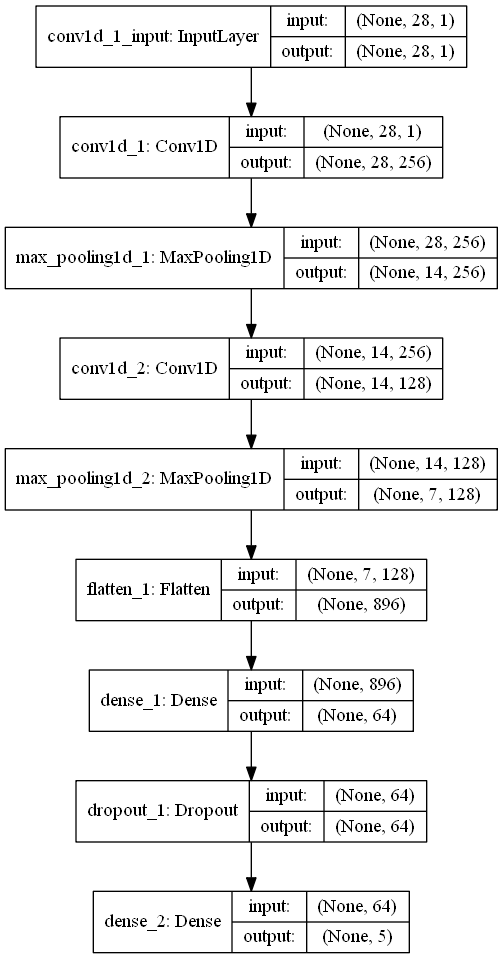

In [10]:
import os
from keras.utils.vis_utils import plot_model
MODEL_VIS_FILE = 'captcha_classfication' + '.png'
os.environ["PATH"] += os.pathsep + 'E:\graphviz-2.38\release\bin'
# 模型可视化
plot_model(model,to_file=MODEL_VIS_FILE,show_shapes=True)

In [11]:

X_predict = model.predict(testdata_cnn)


In [12]:
testlabel.values[:,1],X_predict

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([[4.2922354e-12, 5.9510994e-32, 1.8958456e-20, 5.4517843e-13,
         1.0000000e+00],
        [1.2923222e-12, 8.9085335e-34, 1.4391115e-21, 2.4296933e-13,
         1.0000000e+00],
        [9.9995005e-01, 2.6128458e-10, 4.8377849e-05, 1.3305881e-06,
         2.4598413e-07],
        ...,
        [5.5081737e-01, 3.3335587e-07, 3.8069749e-05, 8.4696148e-05,
         4.4905946e-01],
        [1.0000000e+00, 9.9619308e-15, 3.2950982e-08, 1.6136608e-09,
         3.4397047e-08],
        [1.3053966e-02, 1.1911254e-10, 3.2002916e-08, 9.8694420e-01,
         1.8299362e-06]], dtype=float32))

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [14]:
# 计算每一类的ROC 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(5): 
    fpr[i], tpr[i], _ = roc_curve(testlabel.values[:, i], X_predict[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])

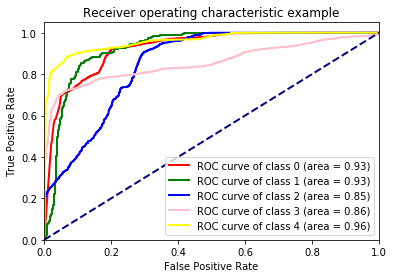

In [15]:
plt.figure() 
lw = 2 
colors = ['red','green','blue','pink','yellow']
for i, color in zip(range(5), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Receiver operating characteristic example') 
plt.legend(loc="lower right") 
plt.show()

In [16]:
for i in range(len(X_predict)):
    max_value = max(X_predict[i])
    for j in range(len(X_predict[i])):
        if max_value == X_predict[i][j]:
            X_predict[i][j] = 1
        else:
            X_predict[i][j] = 0

In [17]:
#darpa数据集验证
from sklearn.metrics import classification_report
print(classification_report(X_predict, testlabel))

              precision    recall  f1-score   support

           0       0.97      0.66      0.79     14141
           1       0.00      0.00      0.00         0
           2       0.14      0.97      0.24       398
           3       0.59      0.78      0.68      1835
           4       0.79      0.96      0.87      6170

   micro avg       0.76      0.76      0.76     22544
   macro avg       0.50      0.67      0.52     22544
weighted avg       0.87      0.76      0.79     22544
 samples avg       0.76      0.76      0.76     22544



E:\Anacoda\envs\tsfenv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [18]:
Week1 = pd.read_csv('datasets/darpa_5/week1.csv',header=None)
Week1_label = pd.read_csv('datasets/darpa_5/week1_label.csv',header=None)
Week2 = pd.read_csv('datasets/darpa_5/week2.csv',header=None)
Week2_label = pd.read_csv('datasets/darpa_5/week2_label.csv',header=None)
Week3 = pd.read_csv('datasets/darpa_5/week3.csv',header=None)
Week3_label = pd.read_csv('datasets/darpa_5/week3_label.csv',header=None)
Week4 = pd.read_csv('datasets/darpa_5/week4.csv',header=None)
Week4_label = pd.read_csv('datasets/darpa_5/week4_label.csv',header=None)
Week5 = pd.read_csv('datasets/darpa_5/week5.csv',header=None)
Week5_label = pd.read_csv('datasets/darpa_5/week5_label.csv',header=None)
Week6 = pd.read_csv('datasets/darpa_5/week6.csv',header=None)
Week6_label = pd.read_csv('datasets/darpa_5/week6_label.csv',header=None)
Week7 = pd.read_csv('datasets/darpa_5/week7.csv',header=None)
Week7_label = pd.read_csv('datasets/darpa_5/week7_label.csv',header=None)

In [19]:
Xall = pd.concat([Week1,Week2,Week3, Week4, Week5, Week6, Week7], axis=0, ignore_index=True)
Yall = pd.concat([Week1_label,Week2_label,Week3_label, Week4_label, Week5_label, Week6_label, Week7_label], axis=0, ignore_index=True)
X_all = ss.transform(Xall)

In [20]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(n_values=5)
def onehot(self):
    return encoder.fit_transform(self.values.reshape(-1,1)).toarray()

Yall_oh = onehot(Yall)

E:\Anacoda\envs\tsfenv\lib\site-packages\sklearn\preprocessing\_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


In [21]:
darpadata_cnn = np.reshape(X_all, (X_all.shape[0], X_all.shape[1], 1))

In [22]:
cnndarpa = model.predict(darpadata_cnn)

In [23]:

for i in range(len(cnndarpa)):
    max_value = max(cnndarpa[i])
    for j in range(len(cnndarpa[i])):
        if max_value == cnndarpa[i][j]:
            cnndarpa[i][j] = 1
        else:
            cnndarpa[i][j] = 0

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(accuracy_score(cnndarpa, Yall_oh))
print(classification_report(cnndarpa, Yall_oh))

0.9713242430357366


E:\Anacoda\envs\tsfenv\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.98      0.97      0.97    899285
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00      1279
           3       0.17      0.34      0.23     23611
           4       1.00      0.99      0.99   1157165

   micro avg       0.97      0.97      0.97   2081340
   macro avg       0.43      0.46      0.44   2081340
weighted avg       0.98      0.97      0.98   2081340
 samples avg       0.97      0.97      0.97   2081340

